In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as mp
%matplotlib inline

pd.set_option("max_colwidth",1000000)
pd.set_option('max_columns', 50)

In [2]:
# Acquisitions_Variables =["LOAN_ID", "ORIG_CHN", "Seller.Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE"
#                            ,"FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", "PROP_TYP"
#                            ,"NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", "RELOCATION_FLG"]
# Performance_Variables = ["LOAN_ID", "Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat"
#                           , "Adj.Month.To.Mat", "Maturity.Date", "MSA", "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
#                           "ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", "TAX_COST", "NS_PROCS",
#                           "CE_PROCS", "RMW_PROCS", "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"]

# Acquisition_ColClasses = ["str", "str", "str", "float", "float", "int", "str", "str", "float",
#                            "float", "str", "float", "float", "str", "str", "str", "str", "str",
#                            "str", "str", "float", "str", "float", "float", "str"]

# Performance_ColClasses = ["str", "str", "str", "float", "float", "float", "float", "float", "str",
#                            "str", "str", "str", "str", "str", "str", "str", "str",
#                            "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "str", "float", "str"]

# Acquisition_dict=dict(zip(Acquisitions_Variables,Acquisition_ColClasses))
# Performance_dict=dict(zip(Performance_Variables,Performance_ColClasses))

        
# Acquisition_date_cols=["ORIG_DTE","FRST_DTE"]
# Performance_date_cols=["Maturity.Date","ZB_DTE", "LPI_DTE","FCC_DTE"]



# Data_A= pd.read_csv('Acquisition_2007Q3.txt', sep='|', 
#                     names=Acquisitions_Variables, 
#                     dtype=Acquisition_dict,
#                     parse_dates=Acquisition_date_cols,
#                     index_col=False)
# Data_P = pd.read_csv('Performance_2007Q3.txt', sep='|', 
#                      names=Performance_Variables, 
#                      dtype=Performance_dict,
#                      parse_dates=Performance_date_cols,
#                      usecols=[0,8,13,14,15], 
#                      index_col=False)

In [2]:
Combined_Variables =["LOAN_ID", "ORIG_CHN", "Seller.Name", "ORIG_RT", "ORIG_AMT", "ORIG_TRM", "ORIG_DTE"
                            ,"FRST_DTE", "OLTV", "OCLTV", "NUM_BO", "DTI", "CSCORE_B", "FTHB_FLG", "PURPOSE", "PROP_TYP"
                            ,"NUM_UNIT", "OCC_STAT", "STATE", "ZIP_3", "MI_PCT", "Product.Type", "CSCORE_C", "MI_TYPE", "RELOCATION_FLG"
                            
                     , "Monthly.Rpt.Prd", "Servicer.Name", "LAST_RT", "LAST_UPB", "Loan.Age", "Months.To.Legal.Mat"
                            , "Adj.Month.To.Mat", "Maturity.Date", "MSA", "Delq.Status", "MOD_FLAG", "Zero.Bal.Code", 
                            "ZB_DTE", "LPI_DTE", "FCC_DTE","DISP_DT", "FCC_COST", "PP_COST", "AR_COST", "IE_COST", "TAX_COST", "NS_PROCS",
                            "CE_PROCS", "RMW_PROCS", "O_PROCS", "NON_INT_UPB", "PRIN_FORG_UPB_FHFA", "REPCH_FLAG", "PRIN_FORG_UPB_OTH", "TRANSFER_FLG"]

Combined_ColClasses = ["str", "str", "str", "float", "float", "int", "str", "str", "float",
                            "float", "str", "float", "float", "str", "str", "str", "str", "str",
                            "str", "str", "float", "str", "float", "float", "str"

                       , "str", "str", "float", "float", "float", "float", "float", "str",
                            "str", "str", "str", "str", "str", "str", "str", "str",
                            "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "float", "str", "float", "str"]

Combined_dict=dict(zip(Combined_Variables,Combined_ColClasses))
Combined_date_cols=["ORIG_DTE","FRST_DTE","Maturity.Date","ZB_DTE", "LPI_DTE","FCC_DTE"]


Combined_Data= pd.read_csv('Combined_Data_2007Q3.txt', sep='|', 
                    names=Combined_Variables, 
                     dtype=Combined_dict,
                     parse_dates=Combined_date_cols,
                    index_col=False)


In [3]:
Combined_Data['ORIG_VAL']=Combined_Data['ORIG_AMT']/(Combined_Data['OLTV']/100)
Combined_Data['OCLTV']=Combined_Data.apply(lambda row : row['OLTV'] if row['OCLTV']==np.nan else row['OCLTV'],axis=1)

Combined_Data['CSCORE_MN']=Combined_Data.apply(lambda row : min(row['CSCORE_B'],row['CSCORE_C']) ,axis=1)


In [14]:
Combined_Data.apply(lambda x: x.isnull().sum(), axis=0)

LOAN_ID                     0
ORIG_CHN                    0
Seller.Name                 0
ORIG_RT                     0
ORIG_AMT                    0
ORIG_TRM                    0
ORIG_DTE                    0
FRST_DTE                    0
OLTV                        0
OCLTV                       0
NUM_BO                     10
DTI                      9143
CSCORE_B                  639
FTHB_FLG                    0
PURPOSE                     0
PROP_TYP                    0
NUM_UNIT                    0
OCC_STAT                    0
STATE                       0
ZIP_3                       0
MI_PCT                 259127
Product.Type                0
CSCORE_C               183703
MI_TYPE                259127
RELOCATION_FLG              0
Monthly.Rpt.Prd             0
Servicer.Name          312326
LAST_RT                     0
LAST_UPB                    3
Loan.Age                    0
Months.To.Legal.Mat         0
Adj.Month.To.Mat        11980
Maturity.Date               0
MSA       

In [9]:
Combined_Data['ZB_DTE'].dt.year.value_counts(dropna=None)

 2009.0    62927
 2010.0    41634
 2008.0    37836
 2012.0    36251
NaN        32687
 2011.0    30187
 2013.0    29395
 2014.0    12353
 2015.0     8940
 2016.0     7910
 2007.0     7517
 2017.0     7086
Name: ZB_DTE, dtype: int64

In [85]:
Data_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314723 entries, 0 to 314722
Data columns (total 25 columns):
LOAN_ID           314723 non-null object
ORIG_CHN          314723 non-null object
Seller.Name       314723 non-null object
ORIG_RT           314723 non-null float64
ORIG_AMT          314723 non-null float64
ORIG_TRM          314723 non-null int32
ORIG_DTE          314723 non-null datetime64[ns]
FRST_DTE          314723 non-null datetime64[ns]
OLTV              314723 non-null float64
OCLTV             314723 non-null float64
NUM_BO            314713 non-null object
DTI               305580 non-null float64
CSCORE_B          314084 non-null float64
FTHB_FLG          314723 non-null object
PURPOSE           314723 non-null object
PROP_TYP          314723 non-null object
NUM_UNIT          314723 non-null object
OCC_STAT          314723 non-null object
STATE             314723 non-null object
ZIP_3             314723 non-null object
MI_PCT            55596 non-null float64
Product

In [67]:
Combined_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314723 entries, 0 to 314722
Data columns (total 26 columns):
LOAN_ID           314723 non-null object
ORIG_CHN          314723 non-null object
Seller.Name       314723 non-null object
ORIG_RT           314723 non-null float64
ORIG_AMT          314723 non-null float64
ORIG_TRM          314723 non-null int32
ORIG_DTE          314723 non-null datetime64[ns]
FRST_DTE          314723 non-null datetime64[ns]
OLTV              314723 non-null float64
OCLTV             314723 non-null float64
NUM_BO            314713 non-null object
DTI               305580 non-null float64
CSCORE_B          314084 non-null float64
FTHB_FLG          314723 non-null object
PURPOSE           314723 non-null object
PROP_TYP          314723 non-null object
NUM_UNIT          314723 non-null object
OCC_STAT          314723 non-null object
STATE             314723 non-null object
ZIP_3             314723 non-null object
MI_PCT            55596 non-null float64
Product

In [17]:
Combined_Data['Default']=Combined_Data['FCC_DTE'].apply(lambda x: 0 if str(x)=='NaT' else 1).astype(int)

In [18]:
Combined_Data['Default'].value_counts(dropna=None)

0    290899
1     23824
Name: Default, dtype: int64

In [10]:
Combined_Data['VinYr']=Combined_Data['ORIG_DTE'].dt.year
Combined_Data['VinYr'].value_counts(dropna=None)

2007    313102
2006      1450
2005        53
2002        48
2001        40
1999        11
2000         7
2004         6
2003         6
Name: VinYr, dtype: int64

In [13]:
Combined_Data['ZB_year']=Combined_Data['ZB_DTE'].dt.year
Combined_Data.groupby(['ZB_year','Zero.Bal.Code']).size()

ZB_year  Zero.Bal.Code
2007.0   1.0               7448
         3.0                  1
         6.0                 68
2008.0   1.0              37209
         2.0                  3
         3.0                 98
         6.0                 69
         9.0                457
2009.0   1.0              60882
         2.0                 24
         3.0                535
         6.0                 74
         9.0               1412
2010.0   1.0              36898
         2.0                113
         3.0               1130
         6.0                 95
         9.0               3398
2011.0   1.0              25225
         2.0                318
         3.0               1302
         6.0                288
         9.0               3054
2012.0   1.0              31644
         2.0                140
         3.0               1243
         6.0                424
         9.0               2800
2013.0   1.0              25362
         2.0                 39
         3.0     

In [121]:
Combined_Data[Combined_Data['Default']==1]['ORIG_DTE'].value_counts(dropna=None)

2007-06-01    7441
2007-07-01    5976
2007-08-01    4359
2007-05-01    4243
2007-04-01     816
2007-09-01     469
2007-03-01     231
2007-02-01     110
2007-01-01      57
2006-12-01      39
2006-10-01      25
2006-11-01      24
2006-09-01      12
2006-08-01       9
2006-07-01       7
2006-02-01       2
2005-12-01       1
2005-10-01       1
2006-01-01       1
2006-05-01       1
Name: ORIG_DTE, dtype: int64

In [122]:
Combined_Data[Combined_Data['Default']==1]['VinYr'].value_counts(dropna=None)

2007    23702
2006      120
2005        2
Name: VinYr, dtype: int64

In [20]:
Combined_Data["ORIG_DTE"].value_counts(dropna=None)

2007-06-01    97627
2007-07-01    81841
2007-08-01    59347
2007-05-01    53369
2007-04-01     9901
2007-09-01     6214
2007-03-01     2992
2007-02-01     1204
2007-01-01      607
2006-12-01      405
2006-10-01      335
2006-11-01      298
2006-08-01      119
2006-09-01      117
2006-07-01       64
2006-05-01       32
2005-11-01       27
2006-06-01       26
2006-02-01       16
2006-03-01       16
2006-04-01       14
2001-06-01       12
2002-03-01       10
2002-02-01        9
2006-01-01        8
2001-08-01        8
2002-01-01        7
2005-12-01        7
2005-09-01        6
2001-09-01        5
              ...  
2002-05-01        2
2001-10-01        2
2004-06-01        2
1999-12-01        2
2003-08-01        2
2005-07-01        2
2001-07-01        2
2000-08-01        1
2002-04-01        1
2003-12-01        1
2003-09-01        1
2000-07-01        1
2003-04-01        1
1999-07-01        1
2002-08-01        1
1999-01-01        1
1999-08-01        1
2003-10-01        1
2000-10-01        1


In [88]:
Combined_Data.loc[Combined_Data['LOAN_ID']=="292258851950",'FCC_DTE']

66772   NaT
Name: FCC_DTE, dtype: datetime64[ns]

,LOAN_ID,ORIG_CHN,Seller.Name,ORIG_RT,ORIG_AMT,ORIG_TRM,ORIG_DTE,FRST_DTE,OLTV,OCLTV,NUM_BO,DTI,CSCORE_B,FTHB_FLG,PURPOSE,PROP_TYP,NUM_UNIT,OCC_STAT,STATE,ZIP_3,MI_PCT,Product.Type,CSCORE_C,MI_TYPE,RELOCATION_FLG,FCC_DTE,Default
244688,800437850380,B,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6.375,132000.0,180,2007-06-01,2007-08-01,80.0,80.0,2,4.0,644.0,N,P,PU,1,I,TX,750,NaN,FRM,NaN,NaN,N,NaT,1
197373,664074796228,C,"CITIMORTGAGE, INC.",6.000,406000.0,360,2007-05-01,2007-07-01,59.0,59.0,1,36.0,806.0,N,P,CO,1,P,CA,906,NaN,FRM,NaN,NaN,N,NaT,1
182207,620499273307,B,"BANK OF AMERICA, N.A.",6.500,417000.0,360,2007-08-01,2007-10-01,77.0,77.0,2,47.0,769.0,Y,P,SF,1,P,CA,907,NaN,FRM,682.0,NaN,N,NaT,1
306595,976601786097,R,"PNC BANK, N.A.",6.375,105000.0,360,2007-06-01,2007-08-01,75.0,75.0,2,26.0,798.0,N,R,PU,1,S,OR,973,NaN,FRM,758.0,NaN,N,NaT,1
60248,273543788155,C,FLAGSTAR CAPITAL MARKETS CORPORATION,6.625,149000.0,360,2007-08-01,2007-10-01,50.0,50.0,1,42.0,673.0,N,C,SF,1,P,CA,925,NaN,FRM,NaN,NaN,N,NaT,1
303796,968793464769,C,"GMAC MORTGAGE, LLC",6.500,270000.0,360,2007-07-01,2007-09-01,62.0,62.0,1,32.0,730.0,N,R,SF,1,P,CA,926,NaN,FRM,NaN,NaN,N,NaT,1
58699,269050187618,B,OTHER,6.875,382000.0,360,2007-07-01,2007-09-01,75.0,75.0,2,63.0,625.0,N,C,SF,1,P,NJ,070,NaN,FRM,630.0,NaN,N,NaT,1
269667,871958094684,C,"BANK OF AMERICA, N.A.",6.125,376000.0,360,2007-06-01,2007-08-01,80.0,80.0,1,36.0,735.0,Y,P,CO,1,P,CA,913,NaN,FRM,NaN,NaN,N,NaT,1
66772,292258851950,C,"BANK OF AMERICA, N.A.",6.375,140000.0,180,2007-07-01,2007-09-01,84.0,84.0,2,37.0,775.0,N,C,SF,1,P,MS,395,6.0,FRM,753.0,2.0,N,NaT,1
114132,426677579712,R,OTHER,6.750,316000.0,360,2007-07-01,2007-09-01,80.0,95.0,2,46.0,796.0,N,P,SF,1,P,NJ,088,NaN,FRM,677.0,NaN,N,NaT,1


In [ ]:
test_rf["Fare"]=test_rf["Fare"].fillna(test_rf["Fare"].median())

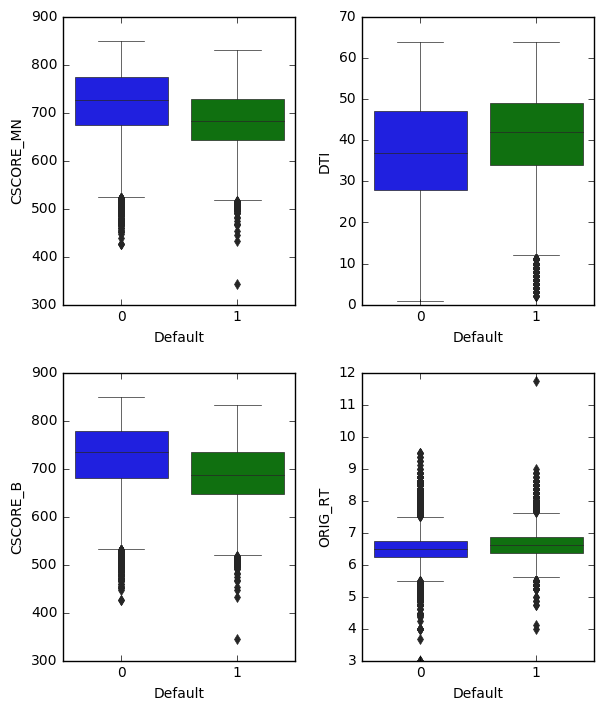

In [19]:
columns = ['CSCORE_MN','DTI','CSCORE_B','ORIG_RT']

fig, axes = mp.subplots(nrows=2, ncols=2, figsize=(6,7))
mp.tight_layout(w_pad=2.0, h_pad=3.0)

for i, column in zip(range(1,5), columns):
    mp.subplot(2,2,i)
    sns.boxplot(x="Default", y=column, data=Combined_Data, linewidth=0.5)
    mp.xlabel('Default')